## In this project, you will work with a dataset containing information about individuals. The goal is to create a model that predicts whether a person is a smoker or not.




In [1]:
import sys
import os
# Añadir el directorio 'functions' al sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'functions')))
import functions as mf


c:\Users\Rodri\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import optuna
import pickle
from collections import Counter

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = '../data/raw/smoking_prediction.csv'
original_df = pd.read_csv(file_path)

df = original_df.copy(deep=True)

# EDA

In [4]:
df = original_df.copy(deep=True)
df.head()

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,3.38,0.04,0.04,0.04,0.04,...,0.51,0.04,0.00,0.75,0.79,1.13,Y,0,Y,0
1,1,F,40,160,60,3.38,0.01,0.00,0.04,0.04,...,0.50,0.04,0.00,0.92,0.79,0.75,Y,0,Y,0
2,2,M,55,170,60,3.33,0.01,0.01,0.04,0.04,...,0.63,0.04,0.04,0.88,0.67,0.92,Y,0,N,1
3,3,M,40,165,70,3.67,0.05,0.05,0.04,0.04,...,0.59,0.04,0.04,0.79,1.08,0.75,Y,0,Y,0
4,4,F,40,155,60,3.58,0.04,0.04,0.04,0.04,...,0.50,0.04,0.00,0.67,0.58,0.92,Y,0,N,0


In [5]:
# Dropeamos la columna ID porque no nos aporta información para la predicción
df.drop(columns='ID', inplace=True)

In [6]:
# Vemos la información de cada columna del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               50000 non-null  object 
 1   age                  50000 non-null  int64  
 2   height(cm)           50000 non-null  int64  
 3   weight(kg)           50000 non-null  int64  
 4   waist(cm)            50000 non-null  float64
 5   eyesight(left)       50000 non-null  float64
 6   eyesight(right)      50000 non-null  float64
 7   hearing(left)        50000 non-null  float64
 8   hearing(right)       50000 non-null  float64
 9   systolic             50000 non-null  float64
 10  relaxation           50000 non-null  float64
 11  fasting blood sugar  50000 non-null  float64
 12  Cholesterol          50000 non-null  float64
 13  triglyceride         50000 non-null  float64
 14  HDL                  50000 non-null  float64
 15  LDL                  50000 non-null 

In [7]:
# Contamos el porcentaje de NaN values en las columnas
(df.isna().sum()/df.shape[0])*100

gender                 0.0
age                    0.0
height(cm)             0.0
weight(kg)             0.0
waist(cm)              0.0
eyesight(left)         0.0
eyesight(right)        0.0
hearing(left)          0.0
hearing(right)         0.0
systolic               0.0
relaxation             0.0
fasting blood sugar    0.0
Cholesterol            0.0
triglyceride           0.0
HDL                    0.0
LDL                    0.0
hemoglobin             0.0
Urine protein          0.0
serum creatinine       0.0
AST                    0.0
ALT                    0.0
Gtp                    0.0
oral                   0.0
dental caries          0.0
tartar                 0.0
smoking                0.0
dtype: float64

In [8]:
df.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,44.189300,164.652000,65.878700,3.415468,0.027999,0.027865,0.041026,0.041048,5.063196,3.167912,...,2.388346,4.791527,0.594483,0.043708,0.018538,1.094032,1.130193,1.668978,0.213120,0.366580
std,12.090086,9.208778,12.831355,0.386760,0.024137,0.024297,0.006325,0.006389,0.570171,0.403353,...,0.615541,1.709246,0.066414,0.017509,0.017504,0.828010,1.327440,2.110348,0.409516,0.481875
min,20.000000,130.000000,30.000000,2.130000,0.000000,0.000000,0.040000,0.040000,2.960000,1.670000,...,0.170000,0.040000,0.170000,0.040000,0.000000,0.250000,0.040000,0.040000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,3.170000,0.010000,0.010000,0.040000,0.040000,4.670000,2.920000,...,1.960000,3.830000,0.550000,0.040000,0.010000,0.790000,0.630000,0.710000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,3.420000,0.040000,0.040000,0.040000,0.040000,5.000000,3.170000,...,2.290000,4.710000,0.590000,0.040000,0.010000,0.960000,0.880000,1.040000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,3.670000,0.040000,0.040000,0.040000,0.040000,5.420000,3.420000,...,2.750000,5.670000,0.630000,0.040000,0.040000,1.210000,1.290000,1.830000,0.000000,1.000000
max,85.000000,190.000000,135.000000,5.380000,0.380000,0.380000,0.080000,0.080000,10.000000,6.080000,...,25.750000,77.500000,0.880000,0.250000,0.460000,54.630000,121.420000,41.630000,1.000000,1.000000


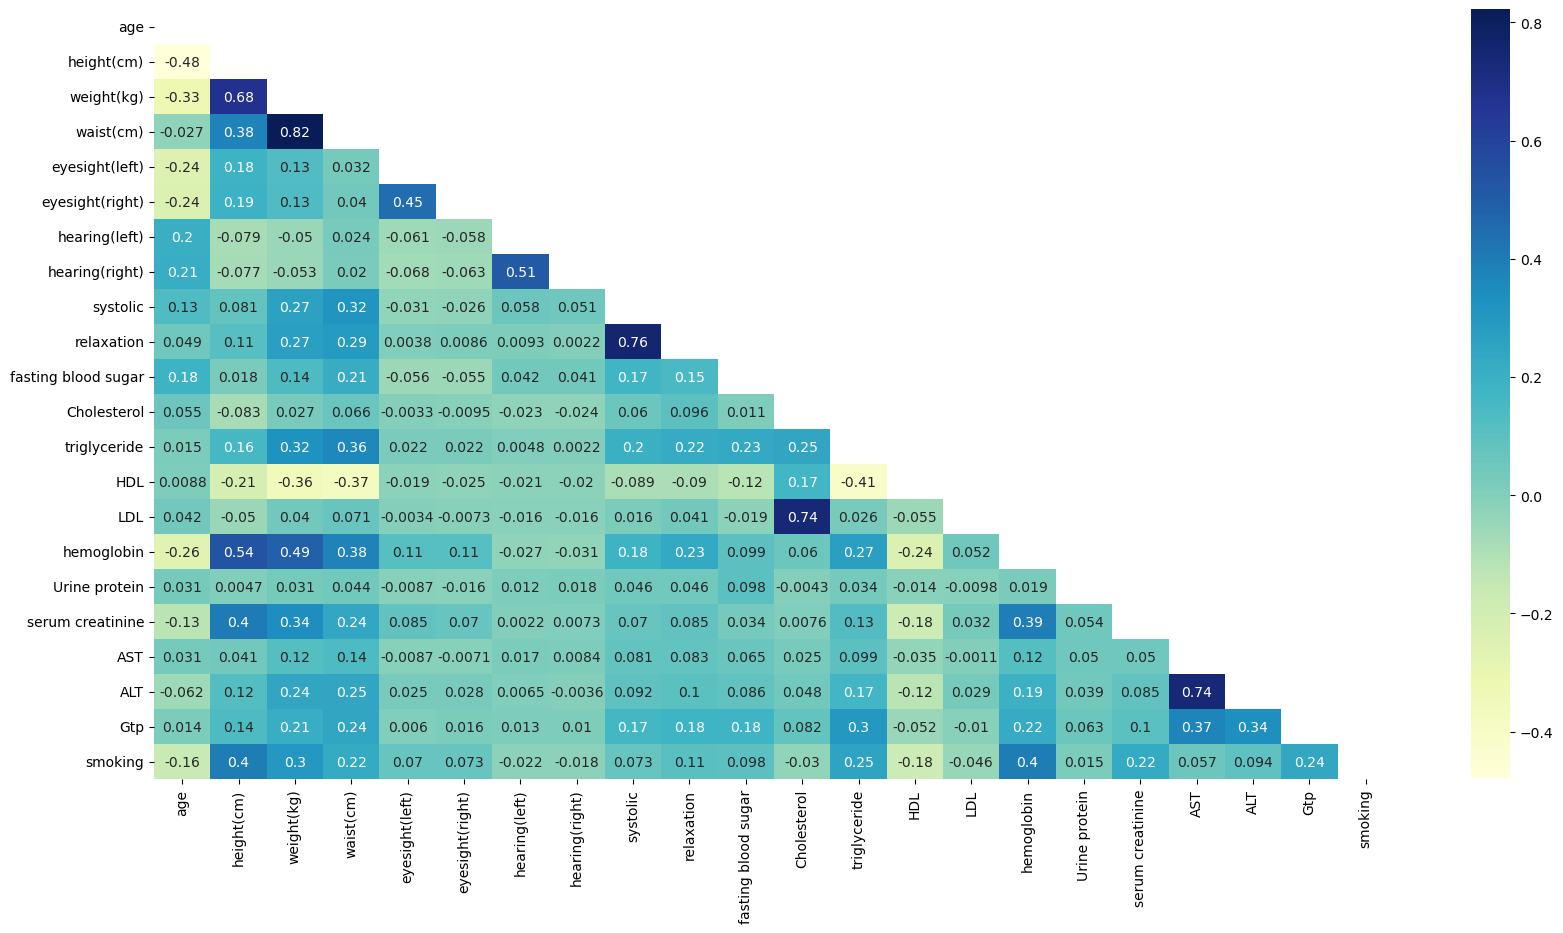

In [9]:
# Eliminamos las columnas con variables categoricas o numericas discretas
columns_drop = ['gender', 'oral', 'dental caries', 'tartar']
df_corr = df.drop(columns=columns_drop)

# Correlation matrix
correlations = df_corr.corr()

# Crear una máscara para la parte superior de la matriz
mask = np.triu(np.ones_like(correlations, dtype=bool))

# Graficar la matriz de correlación con la máscara aplicada
plt.figure(figsize=(20, 10))
sns.heatmap(correlations, mask=mask, annot=True, cmap="YlGnBu")
plt.show()

In [10]:
# Imprimimos los valores únicos de las features y las contamos
columnas = df.columns.tolist()
# Iteramos sobre las columnas y obtenemos los conteos de valores únicos
for columna in columnas:
    # Obtenemos los conteos de valores únicos para la columna actual
    value_counts = df[columna].value_counts()

    # Imprimimos el nombre de la columna
    print("Value counts for '{}':".format(columna))

    # Imprimimos los conteos de valores únicos
    print(value_counts)

Value counts for 'gender':
M    31784
F    18216
Name: gender, dtype: int64
Value counts for 'age':
40    13604
45     6328
60     5531
50     4969
55     4508
35     4024
30     3623
25     3205
20     1430
65     1201
70      748
75      555
80      260
85       14
Name: age, dtype: int64
Value counts for 'height(cm)':
170    10237
165     8917
160     7970
175     7202
155     6841
150     4034
180     2829
145     1120
185      617
140      194
190       33
135        5
130        1
Name: height(cm), dtype: int64
Value counts for 'weight(kg)':
65     7356
60     7276
70     6955
55     6560
75     5458
50     4993
80     3711
85     2286
45     2130
90     1336
95      720
40      428
100     390
105     180
110      99
115      45
35       35
120      23
125       8
30        6
130       4
135       1
Name: weight(kg), dtype: int64
Value counts for 'waist(cm)':
3.42    2204
3.38    2146
3.50    2007
3.46    2005
3.25    1978
        ... 
4.76       1
2.21       1
5.38       1
5.13

In [11]:
# Podemos eliminar el feature 'oral' ya que todos sus valores son 'Y'
df.drop(columns='oral', inplace=True)

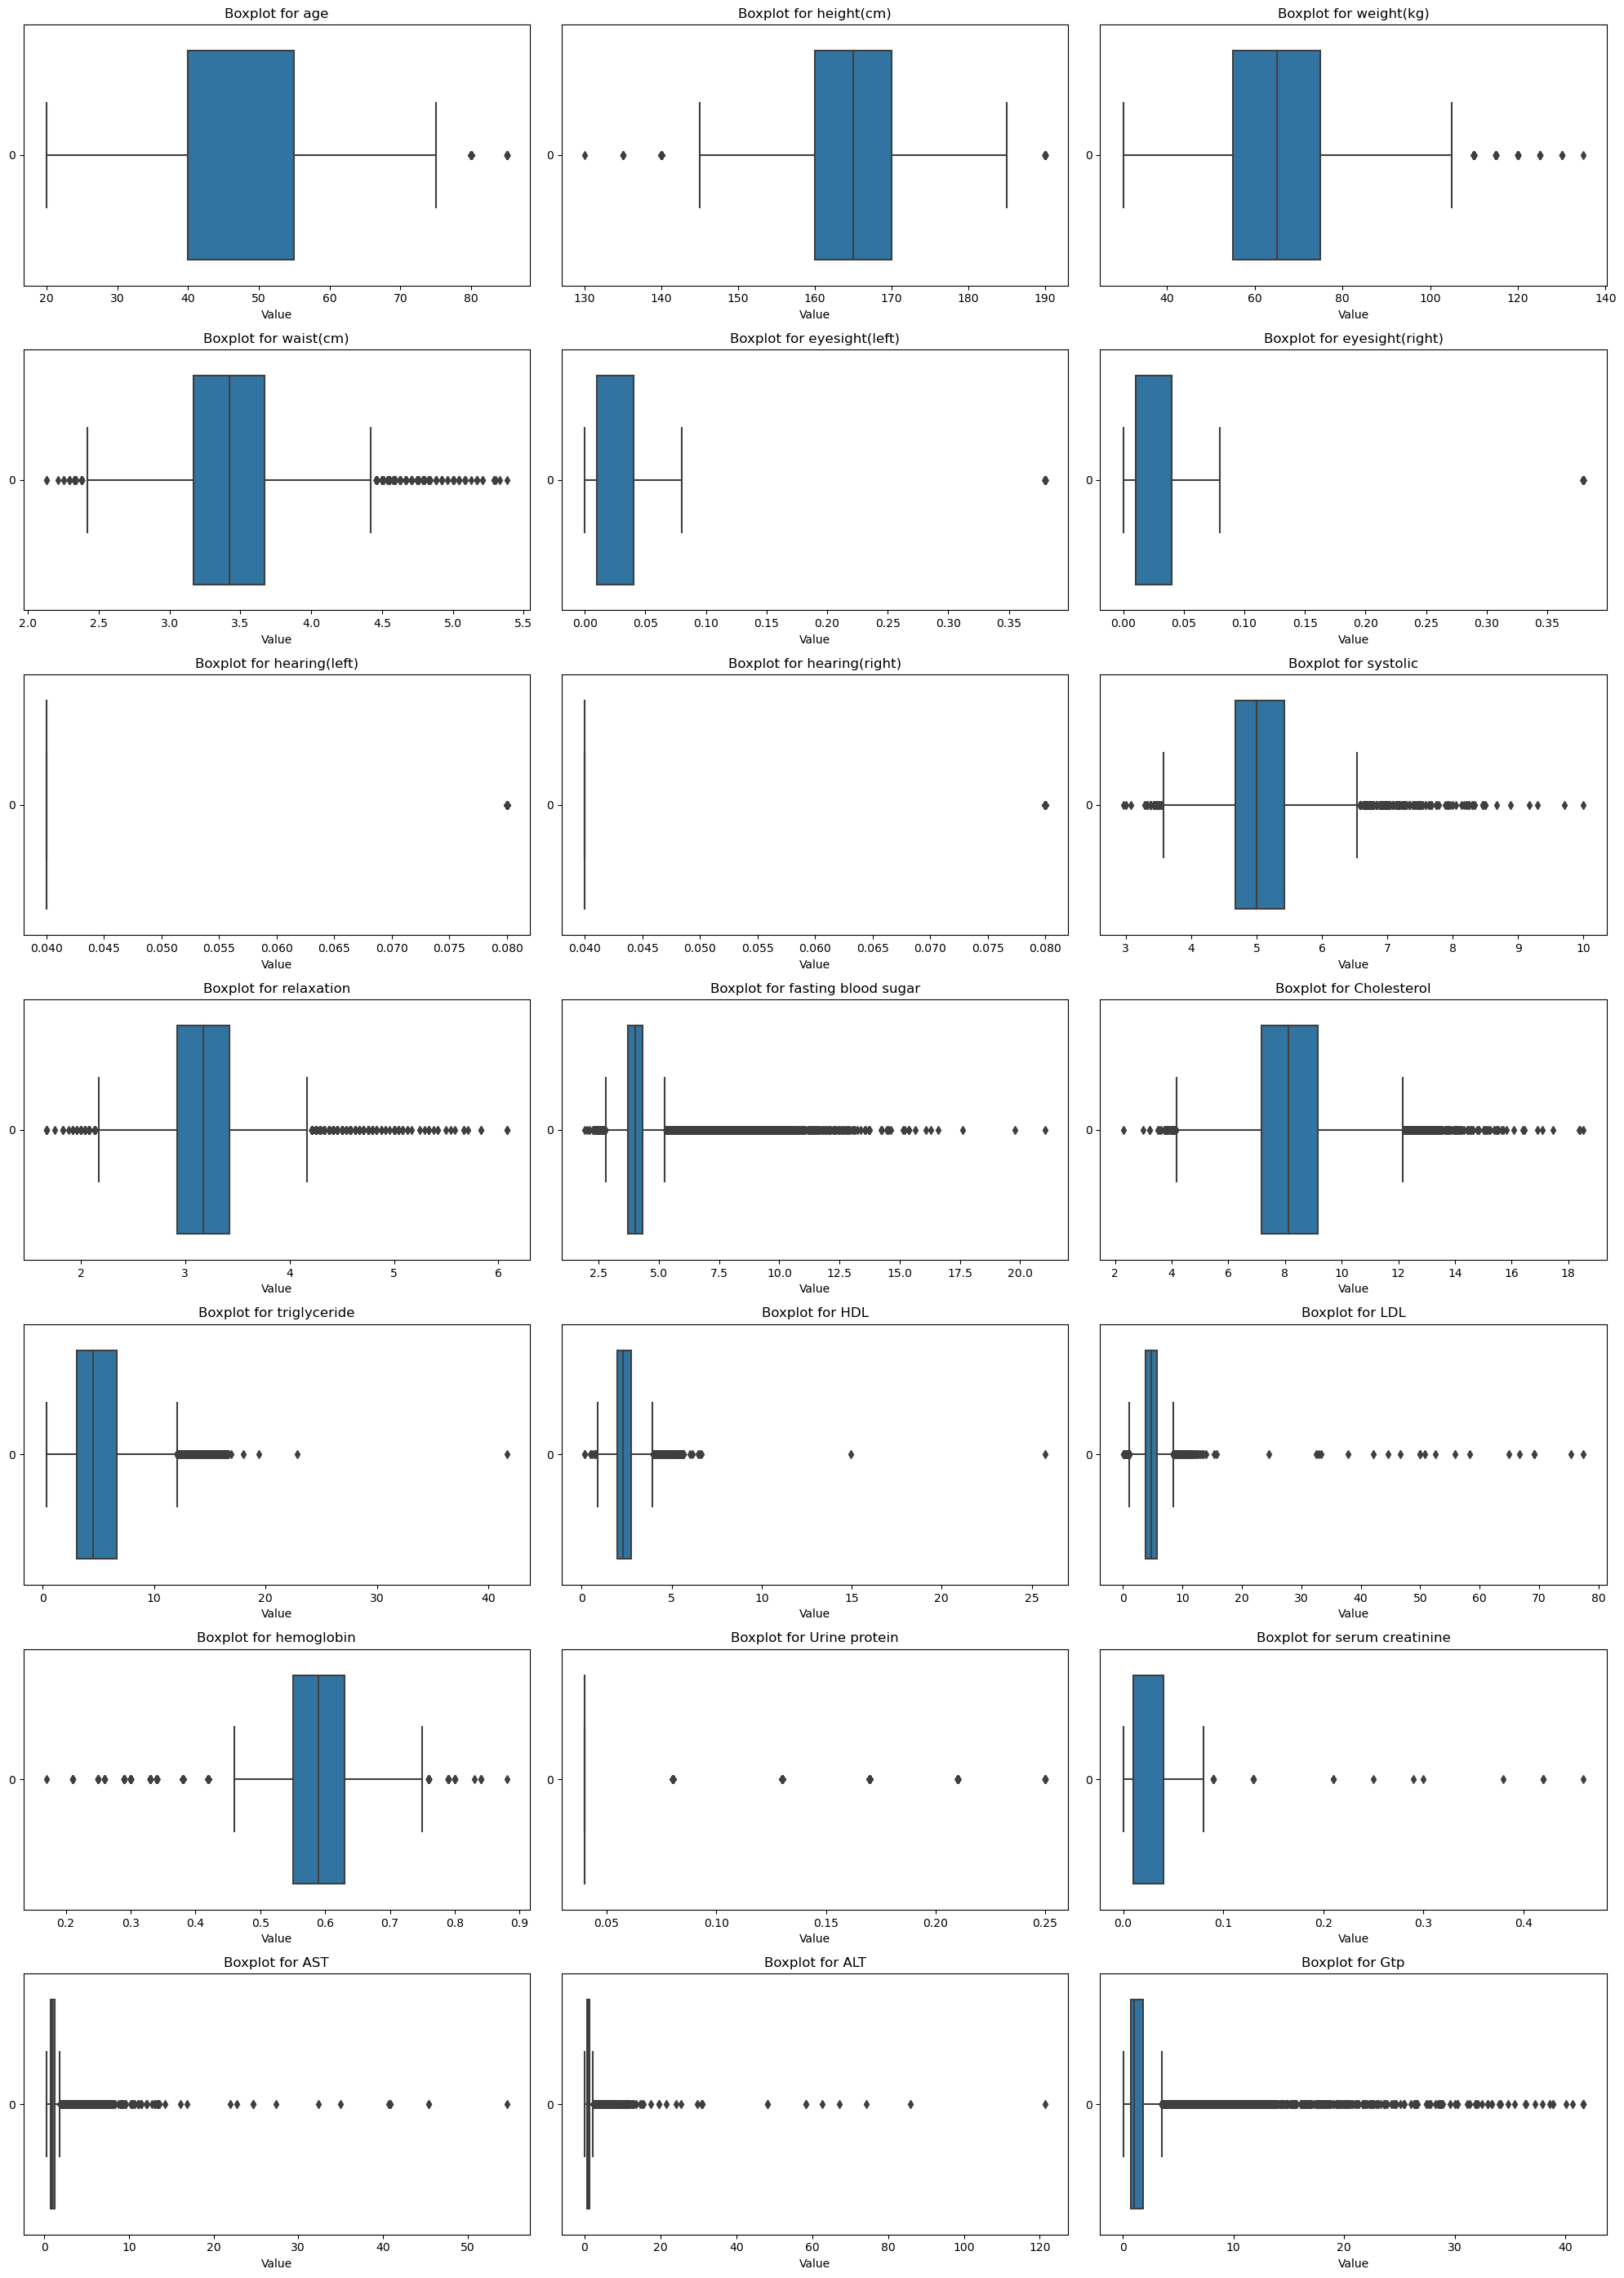

In [12]:
# Hacemos un gráfico de cajas para observar cómo se repiten los valores en cada variables y cómo se comportan los outliers
columns_drop = ['gender', 'dental caries', 'tartar'] # eliminamos estas columnas porque tienen valores categóricos
df_box_graficar = df.drop(columns=columns_drop)

mf.graficar_box(df_box_graficar)

 Del gráfico de cajas se pueden observar valores atípicos en los features "waist(cm)", "eyesight", "hearing" ,"systolic", "relaxation", "fasting blood sugar", "cholesterol" "triglyrecide", "HDL", "LDL", "hemoglobin","Urine protein", "serum creatinine", "AST", "ATL" y "GTP". Viendo los valores promedio de los gráficos de caja e investigando valores normales de estos tipos de estudios médicos, al parecer los que se encuentran en este dataframe están en relación  1:25.

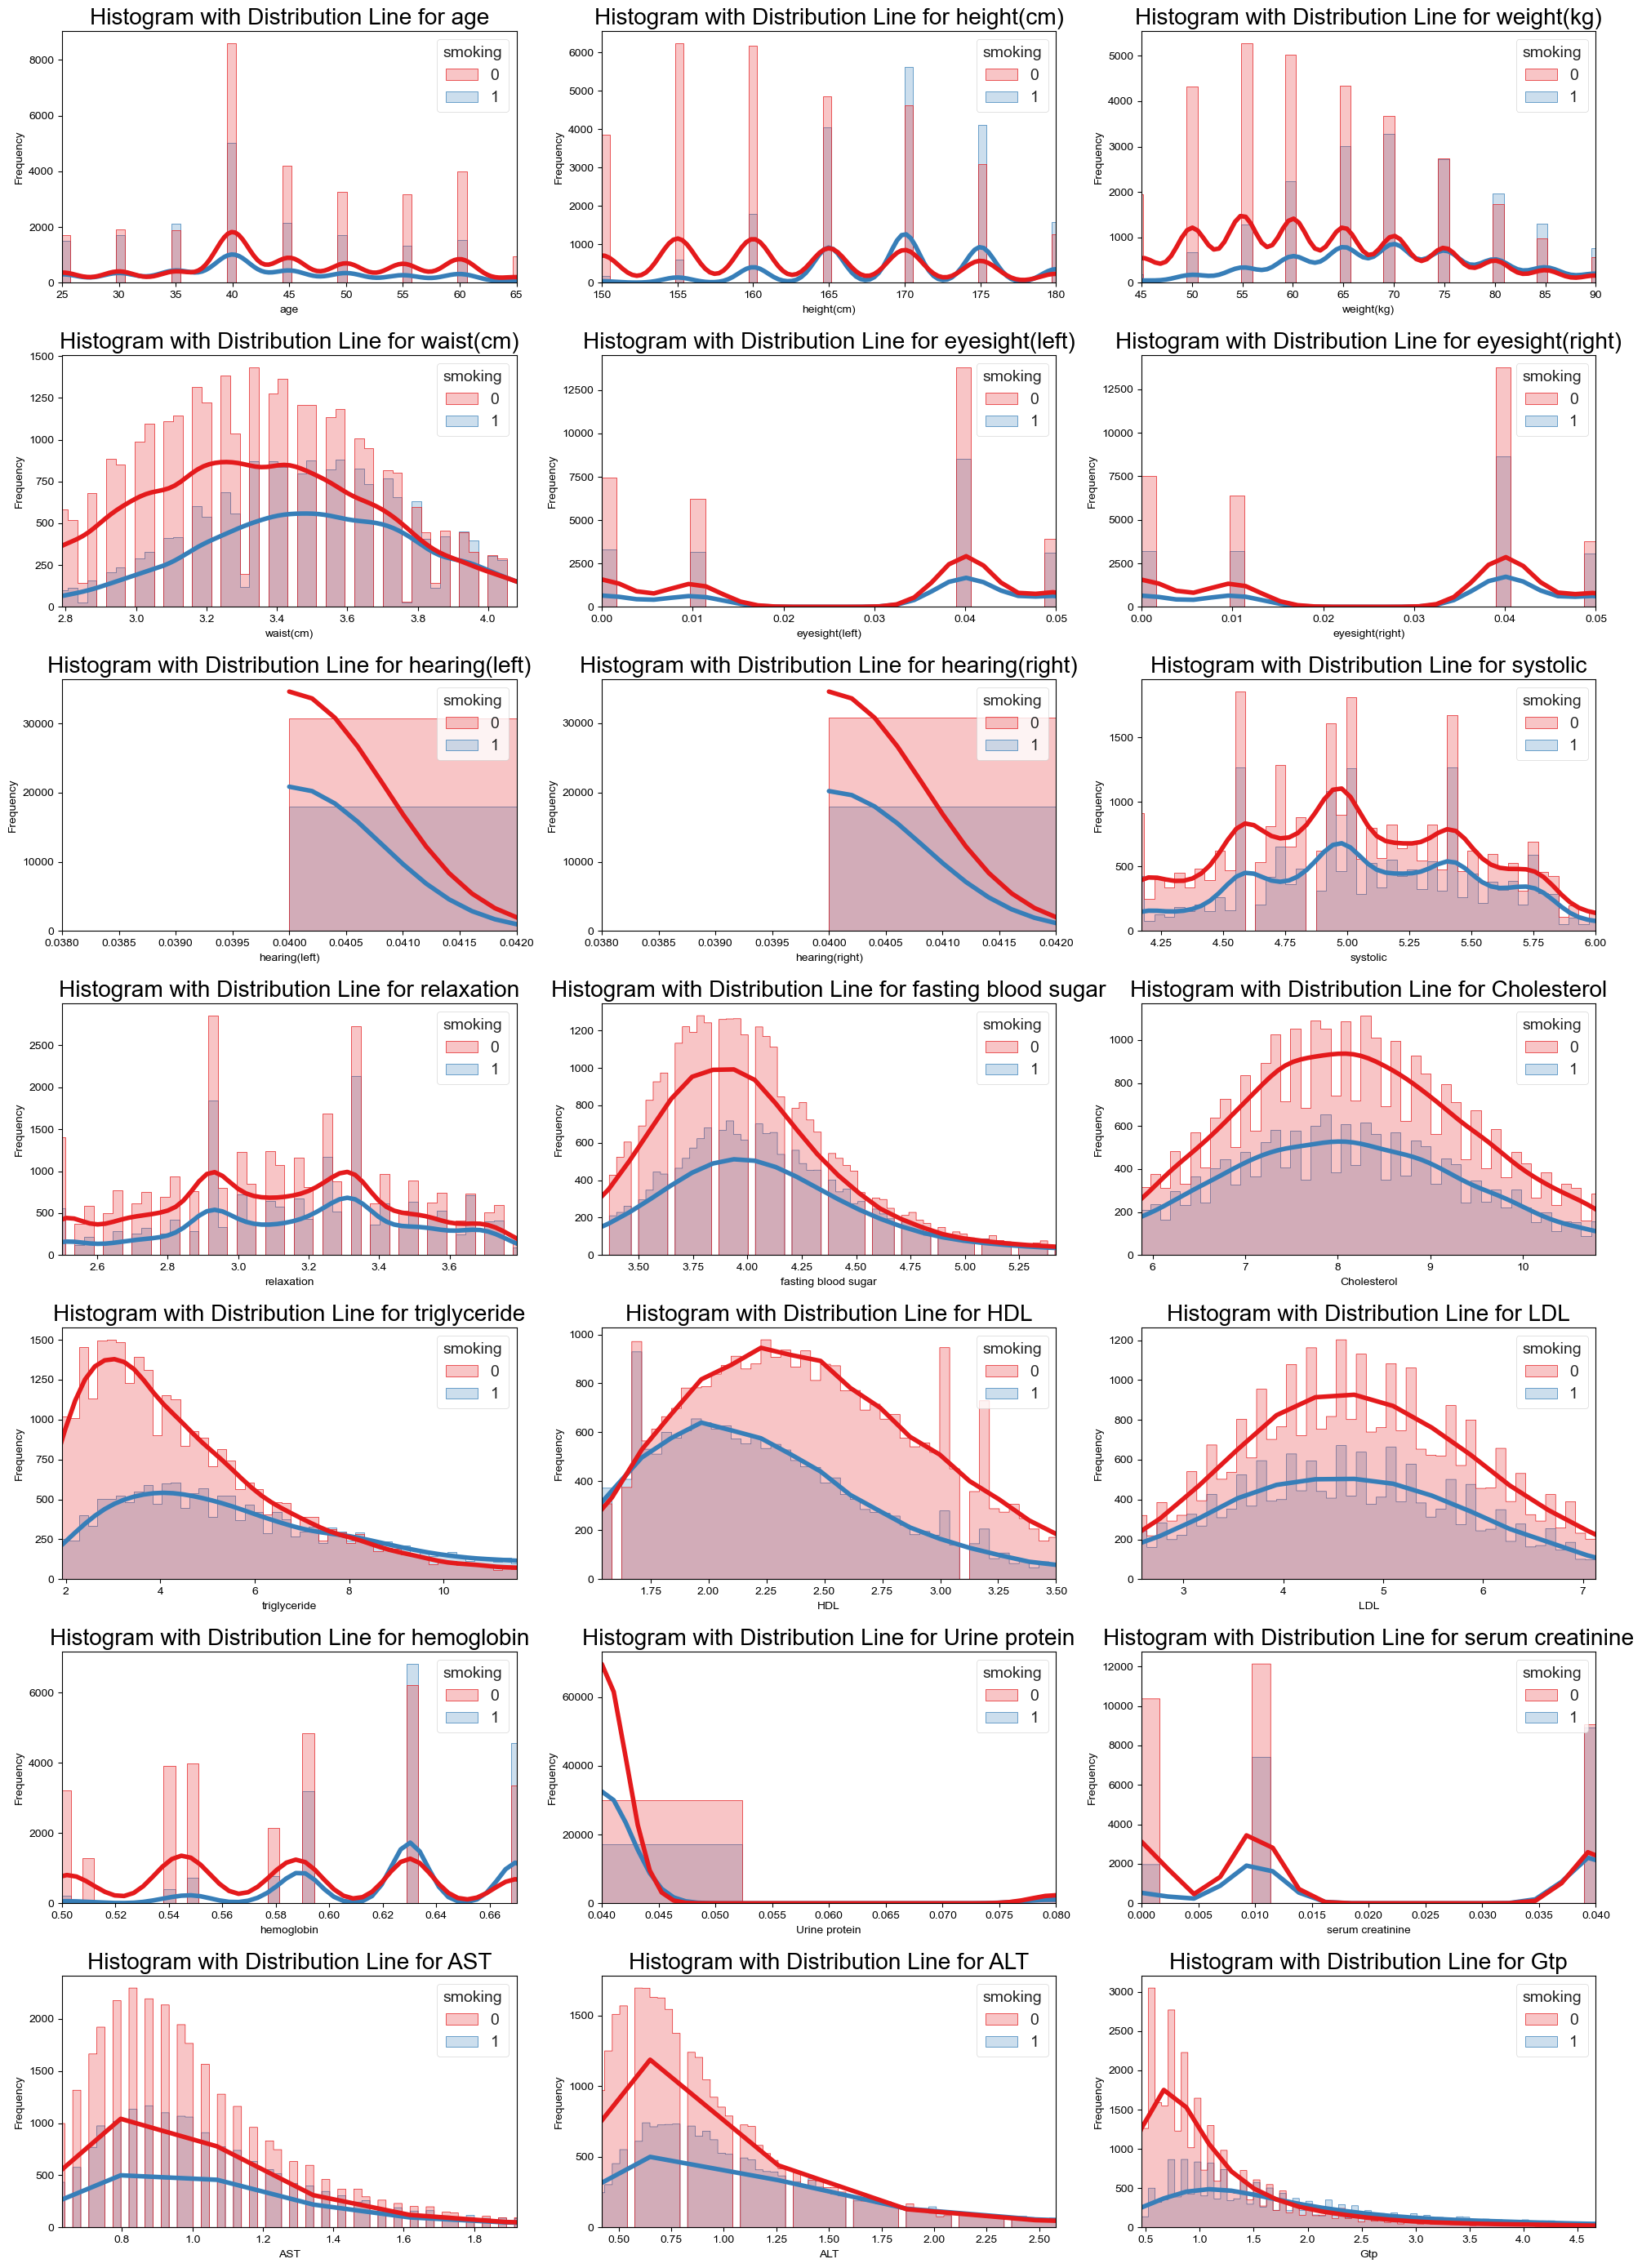

In [13]:
# Especificamos las columnas a eliminar
columns_drop = ['gender', 'dental caries', 'tartar']

# Eliminamos las columnas especificadas
df_distribucion = df.drop(columns=columns_drop)

mf.graficar_dist(df_distribucion)

Graficamos el conteo de fumadores y no fumadores para las variables categóricas.

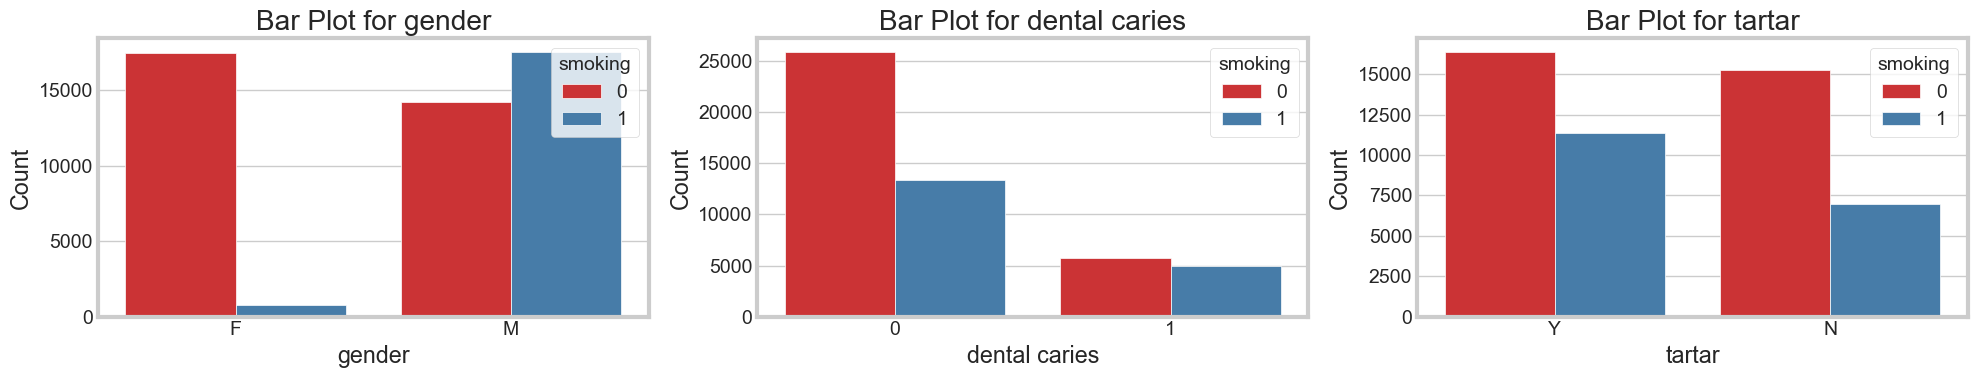

In [14]:
# Especificar las columnas categóricas a graficar
columns_categorical_graficar = ['gender', 'dental caries', 'tartar']


mf.graficar_hist(df,columns_categorical_graficar)

In [15]:
# Contamos los valores 'F' en la columna gender
conteo_F = (df['gender'] == 'F').sum()
# Contamos las filas donde gender es 'F' y smoking es 1
conteo_FyS = ((df['gender'] == 'F') & (df['smoking'] == 1)).sum()

porcentaje_FyS = (conteo_FyS / conteo_F) * 100

print(f"Porcentaje de fumadores en mujeres: {porcentaje_FyS:.2f}%")

Porcentaje de fumadores en mujeres: 4.28%


In [16]:
# Contar los valores 'M' en la columna gender
conteo_M = (df['gender'] == 'M').sum()
# Contar las filas donde gender es 'M' y smoking es 1
conteo_MyS = ((df['gender'] == 'M') & (df['smoking'] == 1)).sum()

porcentaje_MyS = (conteo_MyS / conteo_M) * 100

print(f"Porcentaje de fumadores en hombres: {porcentaje_MyS:.2f}%")

Porcentaje de fumadores en hombres: 55.22%


Podemos observar que el género es un factor muy determinante en el caso de las mujeres, ya que solo el 4.28% de ellas son fumadoras. Por lo tanto, podemos establecer una regla estricta: si se trata de una mujer y asumimos que no es fumadora, la precisión de nuestro modelo en este caso sería del 95.72%.
Procederemos a entrenar nuestro modelo únicamente con los datos del género masculino, que además tiene los datos balanceados ya que el el 55.22% de los hombres son fumadores y el 44.78% no.

In [17]:
# Usamos los datos de 'gender' == M únicamente
df_M = df[df['gender'] == 'M'].reset_index(drop=True)
df_M['gender'] = df_M['gender'].replace({'M': 1, 'F': 0})
# Encodeamos el tartar para que lo pueda utilizar nuestro modelo
df_M['tartar'] = df_M['tartar'].replace({'Y': 1, 'N': 0})

In [18]:
df_M.head()

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,1,55,170,60,3.33,0.01,0.01,0.04,0.04,5.75,...,6.29,0.63,0.04,0.04,0.88,0.67,0.92,0,0,1
1,1,40,165,70,3.67,0.05,0.05,0.04,0.04,4.17,...,9.42,0.59,0.04,0.04,0.79,1.08,0.75,0,1,0
2,1,30,180,75,3.54,0.04,0.04,0.04,0.04,5.33,...,5.38,0.67,0.04,0.04,0.75,1.13,1.38,0,1,0
3,1,40,160,60,3.55,0.04,0.04,0.04,0.04,4.83,...,6.54,0.71,0.04,0.00,0.88,1.13,1.63,1,1,1
4,1,45,165,90,4.00,0.04,0.04,0.04,0.04,6.38,...,5.58,0.63,0.04,0.04,1.58,2.96,4.63,0,1,0


Volvemos a graficar las distribuciones para saber qué variables normalizar y escalar 


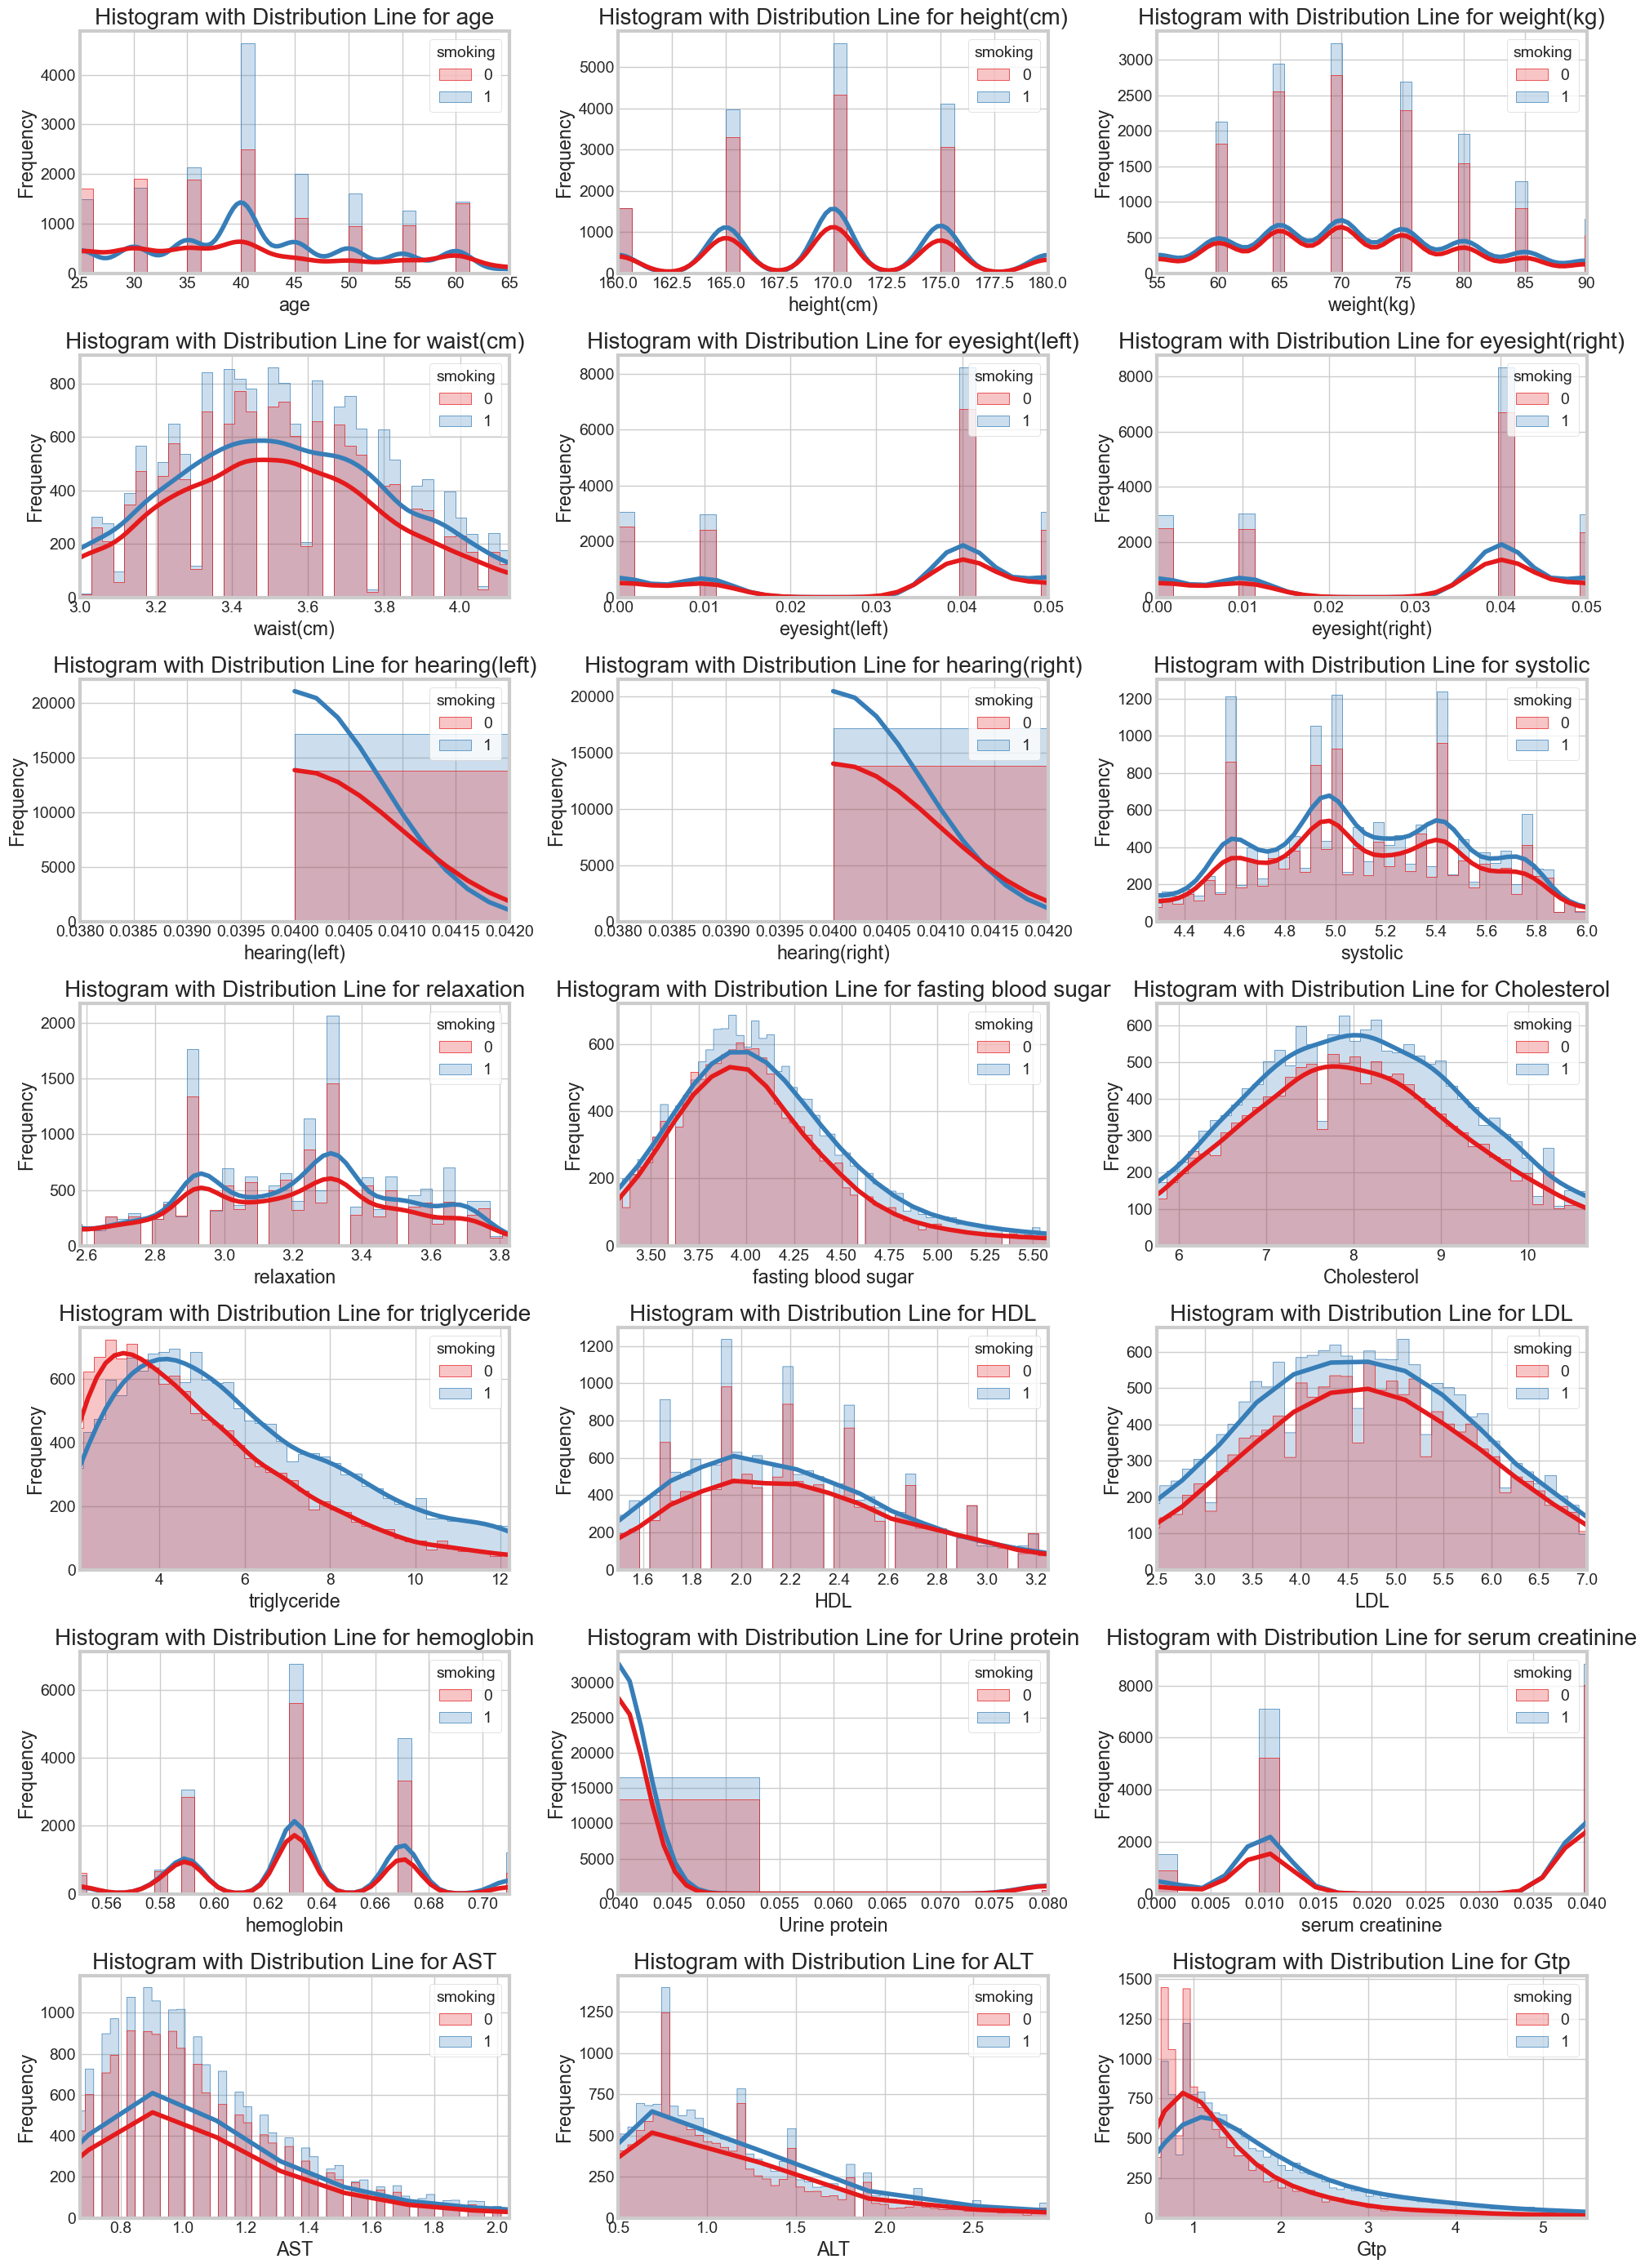

In [19]:
# Especificamos las columnas a eliminar
columns_drop = ['dental caries', 'tartar','gender']

# Eliminamos las columnas especificadas
df_dist_M = df_M.drop(columns=columns_drop)

# Graficamos las distribuciones
mf.graficar_dist(df_dist_M)

De los gráficos podemos observar que:
- Las variables age, height, weight, waist, systolic, relaxation, cholesterol, LDL y hemoglobin tienen distribucion normal 
- Las variables  fasting blood sugar, triglyceride, HDL, AST, ALT, Gtp y Urine protein tienen distribución asimétrica positiva


Normalizamos las columnas de variables con distribuciones asimétricas

In [20]:
# Transformamos las features que tienen distribuciones asimétricas del df_M
mf.transformar_asimetricas(df_M)

Una vez normalizados los datos los escalamos

In [21]:
# Especificamos las columnas que deseas normalizar
columns_to_normalize = ['age', 'height(cm)', 'weight(kg)','systolic','relaxation','fasting blood sugar','Cholesterol','triglyceride','HDL','LDL','hemoglobin','Urine protein','AST','serum creatinine','AST','ALT','Gtp','eyesight(left)', 'eyesight(right)', 'hearing(left)','hearing(right)']  

# Normalizamos las features con distribuciones normales del df_M
mf.normalizar(df_M,columns_to_normalize)

Ahora haremos el encoding de las columnas con variables cuantitativas discretas con OneHotEnconder

In [22]:
df_M.columns

Index(['gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'tartar',
       'smoking'],
      dtype='object')

In [23]:
# Encodeamos las columnas tartar y dental caries
columns_to_encode = ['tartar','dental caries']
df_M = mf.encode_df(df_M,columns_to_encode)
df_M.head()

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,Urine protein,serum creatinine,AST,ALT,Gtp,smoking,tartar_0,tartar_1,dental caries_0,dental caries_1
0,1,0.538462,0.555556,0.210526,3.33,0.026316,0.026316,0.0,0.0,0.396307,...,0.0,0.095238,0.108222,0.092139,0.165109,1,1.0,0.0,1.0,0.0
1,1,0.307692,0.444444,0.315789,3.67,0.131579,0.131579,0.0,0.0,0.171875,...,0.0,0.095238,0.094126,0.138549,0.140142,0,0.0,1.0,1.0,0.0
2,1,0.153846,0.777778,0.368421,3.54,0.105263,0.105263,0.0,0.0,0.336648,...,0.0,0.095238,0.087632,0.143571,0.222948,0,0.0,1.0,1.0,0.0
3,1,0.307692,0.333333,0.210526,3.55,0.105263,0.105263,0.0,0.0,0.265625,...,0.0,0.000000,0.108222,0.143571,0.249846,1,0.0,1.0,0.0,1.0
4,1,0.384615,0.444444,0.526316,4.00,0.105263,0.105263,0.0,0.0,0.485795,...,0.0,0.095238,0.199171,0.274661,0.454817,0,0.0,1.0,1.0,0.0


Realizamos el split del dataset en train y test

In [24]:
x=df_M.drop('smoking', axis=1).copy()
y=df_M.smoking.copy()


In [25]:
X_train, X_test, y_train, y_test = mf.split(df_M)

In [26]:
X_train

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,tartar_0,tartar_1,dental caries_0,dental caries_1
23191,1,0.230769,0.444444,0.263158,3.33,0.131579,0.131579,0.0,0.0,0.372159,...,0.603175,0.000000,0.023810,0.108222,0.117178,0.249846,0.0,1.0,1.0,0.0
15770,1,0.307692,0.777778,0.421053,3.38,0.105263,0.131579,0.0,0.0,0.330966,...,0.603175,0.000000,0.095238,0.087632,0.111480,0.146228,0.0,1.0,1.0,0.0
27556,1,0.307692,0.444444,0.210526,3.17,0.131579,0.026316,0.0,0.0,0.230114,...,0.603175,0.000000,0.095238,0.120196,0.121629,0.181435,0.0,1.0,0.0,1.0
14452,1,0.307692,0.444444,0.263158,3.38,0.105263,0.105263,0.0,0.0,0.301136,...,0.603175,0.000000,0.095238,0.159845,0.106808,0.306849,1.0,0.0,0.0,1.0
27055,1,0.000000,0.555556,0.368421,3.25,0.131579,0.210526,0.0,0.0,0.230114,...,0.666667,0.000000,0.095238,0.457064,0.248558,0.112622,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4776,1,0.461538,0.555556,0.210526,3.54,0.105263,0.026316,0.0,0.0,0.278409,...,0.460317,0.000000,0.023810,0.080988,0.075007,0.227436,0.0,1.0,1.0,0.0
16650,1,0.076923,0.666667,0.526316,3.71,0.131579,0.105263,0.0,0.0,0.289773,...,0.666667,0.000000,0.095238,0.144096,0.215971,0.303514,0.0,1.0,0.0,1.0
4477,1,0.307692,0.333333,0.157895,3.13,0.131579,0.131579,0.0,0.0,0.284091,...,0.603175,0.000000,0.023810,0.154691,0.063730,0.152180,1.0,0.0,1.0,0.0
19477,1,0.307692,0.666667,0.473684,4.00,0.105263,0.105263,0.0,0.0,0.478693,...,0.730159,0.205197,0.023810,0.087632,0.102030,0.257916,0.0,1.0,1.0,0.0


# Empezamos a entrenar y probar los modelos

## Random Forest Classifier

In [27]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_rfc = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')
clf_rfc.fit(X_train, y_train)

CPU times: total: 2.36 s
Wall time: 525 ms


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [28]:
train_pred=clf_rfc.predict(X_train)
test_pred = clf_rfc.predict(X_test)

print(classification_report(y_train,train_pred))
print('---------------------------------------------------------------')
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74     11387
           1       0.80      0.77      0.78     14040

    accuracy                           0.77     25427
   macro avg       0.76      0.77      0.76     25427
weighted avg       0.77      0.77      0.77     25427

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      2847
           1       0.69      0.67      0.68      3510

    accuracy                           0.65      6357
   macro avg       0.65      0.65      0.65      6357
weighted avg       0.65      0.65      0.65      6357



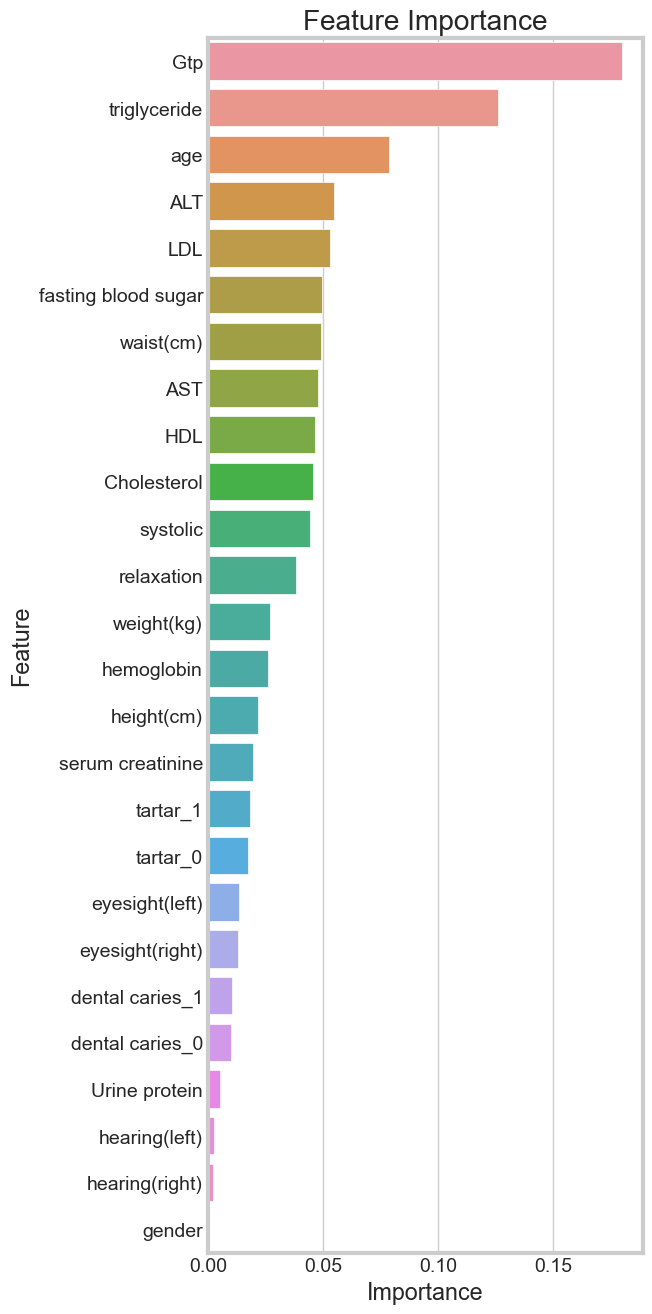

In [29]:
mf.plot_feature_importance(X_train, clf_rfc)

In [30]:
'''%%time
# Wrapper function to include training data
def objective_wrapper(trial):
    return mf.objective_rfc(trial, X_train, y_train)

# Creamos el estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_wrapper, n_trials=20)

# Mostramos los mejores hiperparámetros encontrados
print("Número de pruebas: ", study.trials)
print("Mejores hiperparámetros: ", study.best_params)
print("Mejor valor objetivo: ", study.best_value)'''

'%%time\n# Wrapper function to include training data\ndef objective_wrapper(trial):\n    return mf.objective_rfc(trial, X_train, y_train)\n\n# Creamos el estudio de Optuna\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective_wrapper, n_trials=20)\n\n# Mostramos los mejores hiperparámetros encontrados\nprint("Número de pruebas: ", study.trials)\nprint("Mejores hiperparámetros: ", study.best_params)\nprint("Mejor valor objetivo: ", study.best_value)'

Mejores hiperparámetros:  {'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'log2'}

Mejor valor objetivo:  0.6285838194654693

Graficamos como varía el accuracy de train y test para elegir el valor de max_depth para no generar under u overfitting.

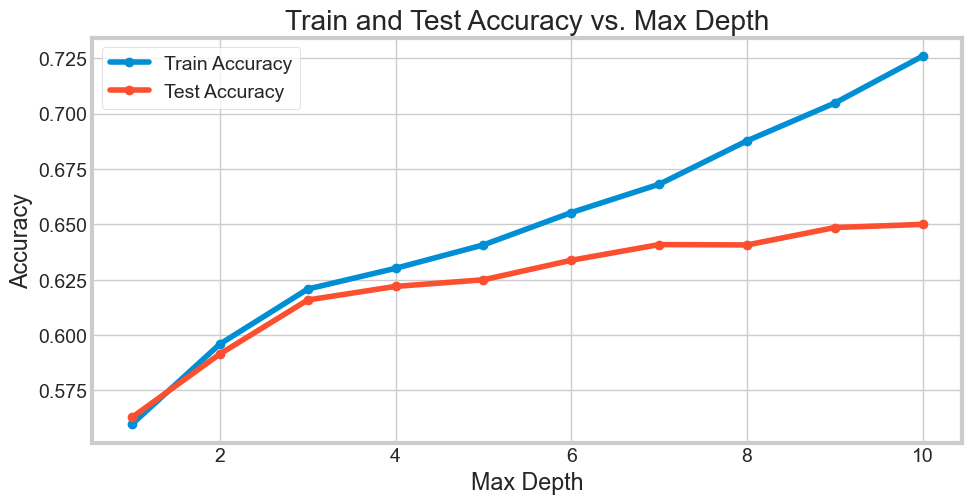

In [31]:
# Lista de max_depth
max_depths = list(range(1, 11))

# Listas para guardar los accuracies
train_accuracies = []
test_accuracies = []

# Parametros iniciales
base_params = {
    'n_estimators': 162,
    'min_samples_split': 9,
    'min_samples_leaf': 10,
    'max_features': 'log2'
}

for max_depth in max_depths:
    # Actualizamos los parámetros con el max_depth actual
    params = base_params.copy()
    params['max_depth'] = max_depth
    
    # Creamos y entrenamos el modelo
    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    
    # Predecimos en el conjunto de entrenamiento y prueba
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    
    # Calculamos el accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Guardamos los resultados
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs. Max Depth')
plt.legend()
plt.grid(True)
plt.show()

Como observamos en el gráfico anterior, la ganancia de accuracy en test no varía mucho, no así el de train, por lo que mientras mayor el max_depth mucho más overfitting genera. Tomo el valor de 5 ya que desde ese punto se genera un cambio mayor en la pendiente de la curva de train que en la de test.

In [32]:
%%time

clf_rfc = RandomForestClassifier(n_estimators=162, max_depth= 5, min_samples_split=9, min_samples_leaf=10, max_features='log2', n_jobs=-1, random_state=42, class_weight='balanced')
clf_rfc.fit(X_train, y_train)
train_pred=clf_rfc.predict(X_train)
test_pred = clf_rfc.predict(X_test)

print(classification_report(y_train,train_pred))
print('---------------------------------------------------------------')
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.59      0.64      0.61     11387
           1       0.69      0.65      0.67     14040

    accuracy                           0.64     25427
   macro avg       0.64      0.64      0.64     25427
weighted avg       0.65      0.64      0.64     25427

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.60      0.59      2847
           1       0.66      0.64      0.65      3510

    accuracy                           0.62      6357
   macro avg       0.62      0.62      0.62      6357
weighted avg       0.62      0.62      0.62      6357

CPU times: total: 141 ms
Wall time: 429 ms


Guardamos el modelo de Logistic regression en la carpeta models

In [ ]:
mf.save_model(clf_rfc,'modelo_rfc.pkl')

## Logistic Regression Classifier

In [33]:

'''# Wrapper function to include training data
def objective_wrapper_lr(trial):
    return mf.objective_lr(trial, X_train, y_train)

# Creamos el estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_wrapper_lr, n_trials=50)

# Mostramos los mejores hiperparámetros encontrados
print("Número de pruebas: ", len(study.trials))
print("Mejores hiperparámetros: ", study.best_params)
print("Mejor valor objetivo: ", study.best_value)

# Entrenamos el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_model = LogisticRegression(C=best_params['C'], solver=best_params['solver'], max_iter=10000, random_state=42)
best_model.fit(X_train, y_train)

# Evaluamos el modelo en el conjunto de prueba
test_accuracy = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")'''

'# Wrapper function to include training data\ndef objective_wrapper_lr(trial):\n    return mf.objective_lr(trial, X_train, y_train)\n\n# Creamos el estudio de Optuna\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective_wrapper_lr, n_trials=50)\n\n# Mostramos los mejores hiperparámetros encontrados\nprint("Número de pruebas: ", len(study.trials))\nprint("Mejores hiperparámetros: ", study.best_params)\nprint("Mejor valor objetivo: ", study.best_value)\n\n# Entrenamos el modelo final con los mejores hiperparámetros\nbest_params = study.best_params\nbest_model = LogisticRegression(C=best_params[\'C\'], solver=best_params[\'solver\'], max_iter=10000, random_state=42)\nbest_model.fit(X_train, y_train)\n\n# Evaluamos el modelo en el conjunto de prueba\ntest_accuracy = best_model.score(X_test, y_test)\nprint(f"Test accuracy: {test_accuracy}")'

Mejores hiperparámetros:  {'C': 17.448153245663104, 'solver': 'lbfgs', 'max_iter': 356, 'l1_ratio': 0.26120579867172844}

Mejor valor objetivo:  0.6356236082546377

Test accuracy: 0.6278118609406953

In [34]:
%%time

clf_lr = LogisticRegression(C=17.448153245663104, solver='lbfgs', max_iter=356, l1_ratio=0.26120579867172844, random_state=42)
clf_lr.fit(X_train, y_train)
train_pred_lr=clf_lr.predict(X_train)
test_pred_lr = clf_lr.predict(X_test)

print(classification_report(y_train,train_pred_lr))
print('---------------------------------------------------------------')
print(classification_report(y_test, test_pred_lr))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56     11387
           1       0.65      0.72      0.69     14040

    accuracy                           0.64     25427
   macro avg       0.63      0.62      0.62     25427
weighted avg       0.63      0.64      0.63     25427

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.51      0.55      2847
           1       0.65      0.72      0.68      3510

    accuracy                           0.63      6357
   macro avg       0.62      0.62      0.62      6357
weighted avg       0.62      0.63      0.62      6357

CPU times: total: 172 ms
Wall time: 212 ms


Guardamos el modelo de Logistic regression en la carpeta models

In [ ]:
mf.save_model(clf_lr,'modelo_lr.pkl')

Por último entrenaremos XGBoost

In [35]:
'''# Función objetiva para optimización
def objective(trial):
    # Sugerimos valores para los hiperparámetros
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',  # Usamos softmax para clasificación multiclase
        'num_class': 3,  # Cambia según el número de clases en tu dataset
        'eval_metric': 'mlogloss',  # Usamos log loss para la evaluación
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }
    
    # Creamos el clasificador con los hiperparámetros sugeridos
    clf = xgb.XGBClassifier(**param, use_label_encoder=False)
    
    # Evaluamos el modelo usando validación cruzada
    scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
    accuracy = scores.mean()
    
    return accuracy

# Creamos el estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mostramos los mejores hiperparámetros encontrados
print("Número de pruebas: ", len(study.trials))
print("Mejores hiperparámetros: ", study.best_params)
print("Mejor valor objetivo: ", study.best_value)

# Entrenamos el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
best_model.fit(X_train, y_train)

# Evaluamos el modelo en el conjunto de prueba
test_accuracy = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")'''

'# Función objetiva para optimización\ndef objective(trial):\n    # Sugerimos valores para los hiperparámetros\n    param = {\n        \'verbosity\': 0,\n        \'objective\': \'multi:softmax\',  # Usamos softmax para clasificación multiclase\n        \'num_class\': 3,  # Cambia según el número de clases en tu dataset\n        \'eval_metric\': \'mlogloss\',  # Usamos log loss para la evaluación\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 1e-5, 1.0),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 500),\n        \'gamma\': trial.suggest_loguniform(\'gamma\', 1e-8, 1.0),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.5, 1.0),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.5, 1.0),\n        \'lambda\': trial.suggest_loguniform(\'lambda\', 1e-8, 1.0),\n   

Mejores hiperparámetros:  {'max_depth': 10, 'learning_rate': 0.072727013874049, 'n_estimators': 469, 'gamma': 0.0009622848881943641, 'min_child_weight': 9, 'subsample': 0.7192284317194099, 'colsample_bytree': 0.7904656630267645, 'lambda': 0.0011756903538273093, 'alpha': 5.2942921128233334e-06}


Test accuracy: 0.682397357243983

Graficamos como varía el accuracy de train y test para elegir el valor de max_depth para no generar under u overfitting.

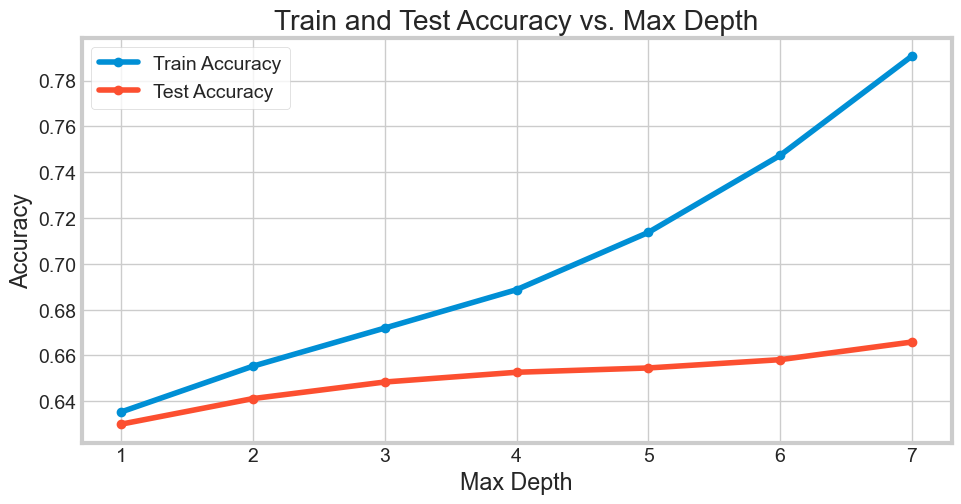

In [36]:
# Lista de max_depth
max_depths = list(range(1, 8))

# Listas para guardar los accuracies
train_accuracies = []
test_accuracies = []

# Parametros iniciales
base_params = {
    'learning_rate': 0.01792702198021698,
    'n_estimators': 497,
    # Agrega otros parámetros si es necesario
}

for max_depth in max_depths:
    # Actualizamos los parámetros con el max_depth actual
    params = base_params.copy()
    params['max_depth'] = max_depth
    
    # Creamos y entrenamos el modelo
    clf = xgb.XGBClassifier(**params, use_label_encoder=False)
    clf.fit(X_train, y_train)
    
    # Predecimos en el conjunto de entrenamiento y prueba
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    
    # Calculamos el accuracy
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Guardamos los resultados
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Graficamos los resultados
plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs. Max Depth')
plt.legend()
plt.grid(True)
plt.show()

Como observamos en el gráfico anterior, la ganancia de accuracy en test no varía mucho, no así el de train, por lo que mientras mayor el max_depth mucho más overfitting genera. Tomo el valor de 3 ya que desde ese punto se genera un cambio mayor en la pendiente de la curva de train que en la de test.

In [37]:
%%time

param = {'max_depth': 3, 'learning_rate': 0.01792702198021698, 'n_estimators': 497}
def xgb_classifier(X_train,X_test,y_train,y_test,param):
    clf = xgb.XGBClassifier(**param, use_label_encoder=False, enable_categorical=True)
    clf.fit(X_train, y_train)
    train_pred=clf.predict(X_train)
    test_pred = clf.predict(X_test)

    print(classification_report(y_train,train_pred))
    print('---------------------------------------------------------------')
    print(classification_report(y_test, test_pred))


CPU times: total: 0 ns
Wall time: 0 ns


In [38]:
xgb_classifier(X_train,X_test,y_train,y_test,param)

              precision    recall  f1-score   support

           0       0.66      0.54      0.60     11387
           1       0.68      0.78      0.72     14040

    accuracy                           0.67     25427
   macro avg       0.67      0.66      0.66     25427
weighted avg       0.67      0.67      0.67     25427

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.52      0.57      2847
           1       0.66      0.76      0.70      3510

    accuracy                           0.65      6357
   macro avg       0.64      0.64      0.64      6357
weighted avg       0.65      0.65      0.64      6357



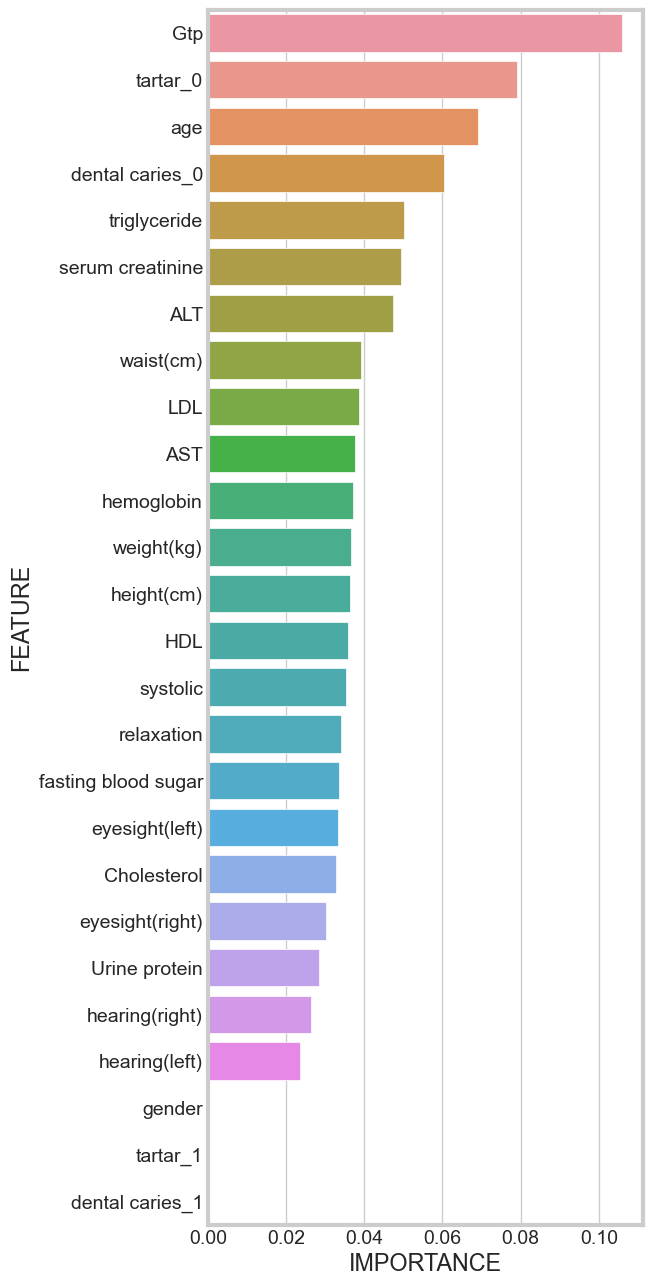

In [39]:
fi = pd.DataFrame(columns=['FEATURE', 'IMPORTANCE'])
fi['FEATURE'] = X_train.columns
fi['IMPORTANCE'] = clf.feature_importances_
fi = fi.sort_values('IMPORTANCE', ascending=False)
plt.figure(figsize=(5,15))
sns.barplot(y=fi.FEATURE, x=fi.IMPORTANCE)
plt.show()

Como podemos observar el modelo que mejor performa es XGBoost por lo cual seguiremos trabajando con este.




## Trabajaremos los outliers para comprobar si el modelo mejora su performance.

In [40]:
columnas_outliers=['weight(kg)','waist(cm)','systolic','relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride','LDL', 'hemoglobin','serum creatinine', 'AST', 'ALT', 'Gtp']



mf.remove_outliers(df, columnas_outliers)

In [41]:
X_train_o, X_test_o, y_train_o, y_test_o = mf.split(df_M)

In [42]:
'''# Función objetiva para optimización
def objective(trial):
    # Sugerimos valores para los hiperparámetros
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',  # Usamos softmax para clasificación multiclase
        'num_class': 3,  # Cambia según el número de clases en tu dataset
        'eval_metric': 'mlogloss',  # Usamos log loss para la evaluación
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }
    
    # Creamos el clasificador con los hiperparámetros sugeridos
    clf = xgb.XGBClassifier(**param, use_label_encoder=False)
    
    # Evaluamos el modelo usando validación cruzada
    scores = cross_val_score(clf, X_train_o, y_train_o, cv=5, n_jobs=-1)
    accuracy = scores.mean()
    
    return accuracy

# Creamos el estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mostramos los mejores hiperparámetros encontrados
print("Número de pruebas: ", len(study.trials))
print("Mejores hiperparámetros: ", study.best_params)
print("Mejor valor objetivo: ", study.best_value)

# Entrenamos el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
best_model.fit(X_train_o, y_train_o)

# Evaluamos el modelo en el conjunto de prueba
test_accuracy = best_model.score(X_test_o, y_test_o)
print(f"Test accuracy: {test_accuracy}")'''

'# Función objetiva para optimización\ndef objective(trial):\n    # Sugerimos valores para los hiperparámetros\n    param = {\n        \'verbosity\': 0,\n        \'objective\': \'multi:softmax\',  # Usamos softmax para clasificación multiclase\n        \'num_class\': 3,  # Cambia según el número de clases en tu dataset\n        \'eval_metric\': \'mlogloss\',  # Usamos log loss para la evaluación\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 1e-5, 1.0),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 500),\n        \'gamma\': trial.suggest_loguniform(\'gamma\', 1e-8, 1.0),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.5, 1.0),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.5, 1.0),\n        \'lambda\': trial.suggest_loguniform(\'lambda\', 1e-8, 1.0),\n   

In [43]:
%%time

param = {'max_depth': 3, 'learning_rate': 0.026936999073596618, 'n_estimators': 494,'gamma': 0.17924070626946773, 'min_child_weight': 1, 'subsample': 0.7245725300134859, 'colsample_bytree': 0.6696120345293278, 'lambda': 6.414180572488689e-06, 'alpha': 5.130620763187064e-06}

xgb_classifier(X_train_o, X_test_o, y_train_o, y_test_o,param)


              precision    recall  f1-score   support

           0       0.67      0.56      0.61     11387
           1       0.68      0.77      0.73     14040

    accuracy                           0.68     25427
   macro avg       0.68      0.67      0.67     25427
weighted avg       0.68      0.68      0.67     25427

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.54      0.58      2847
           1       0.66      0.74      0.70      3510

    accuracy                           0.65      6357
   macro avg       0.65      0.64      0.64      6357
weighted avg       0.65      0.65      0.65      6357

CPU times: total: 3.73 s
Wall time: 429 ms


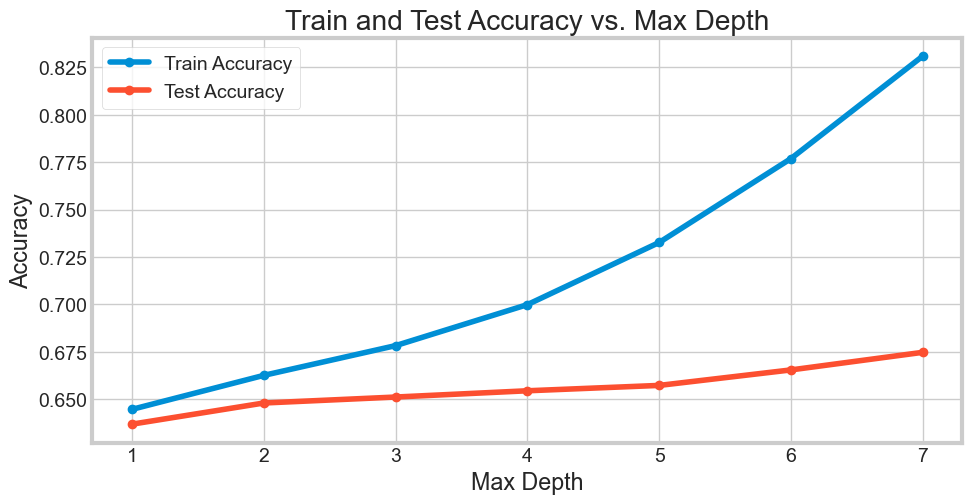

In [44]:
# Lista de max_depth
max_depths = list(range(1, 8))

# Listas para guardar los accuracies
train_accuracies = []
test_accuracies = []

# Parametros iniciales
base_params = {
    'learning_rate': 0.026936999073596618,
    'n_estimators': 494,
    'gamma': 0.17924070626946773,
    'min_child_weight': 1,
    'subsample': 0.7245725300134859,
    'colsample_bytree': 0.6696120345293278,
    'lambda': 6.414180572488689e-06,
    'alpha': 5.130620763187064e-06
}

for max_depth in max_depths:
    # Actualizamos los parámetros con el max_depth actual
    params = base_params.copy()
    params['max_depth'] = max_depth
    
    # Creamos y entrenar el modelo
    clf = xgb.XGBClassifier(**params, use_label_encoder=False)
    clf.fit(X_train_o, y_train_o)
    
    # Predecimos en el conjunto de entrenamiento y prueba
    train_pred_o = clf.predict(X_train_o)
    test_pred_o = clf.predict(X_test_o)
    
    # Calculamos  accuracy
    train_accuracy = accuracy_score(y_train_o, train_pred_o)
    test_accuracy = accuracy_score(y_test_o, test_pred_o)
    
    # Guardamos los resultados
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Graficar los resultados
plt.figure(figsize=(10, 5))
plt.plot(max_depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs. Max Depth')
plt.legend()
plt.grid(True)
plt.show()

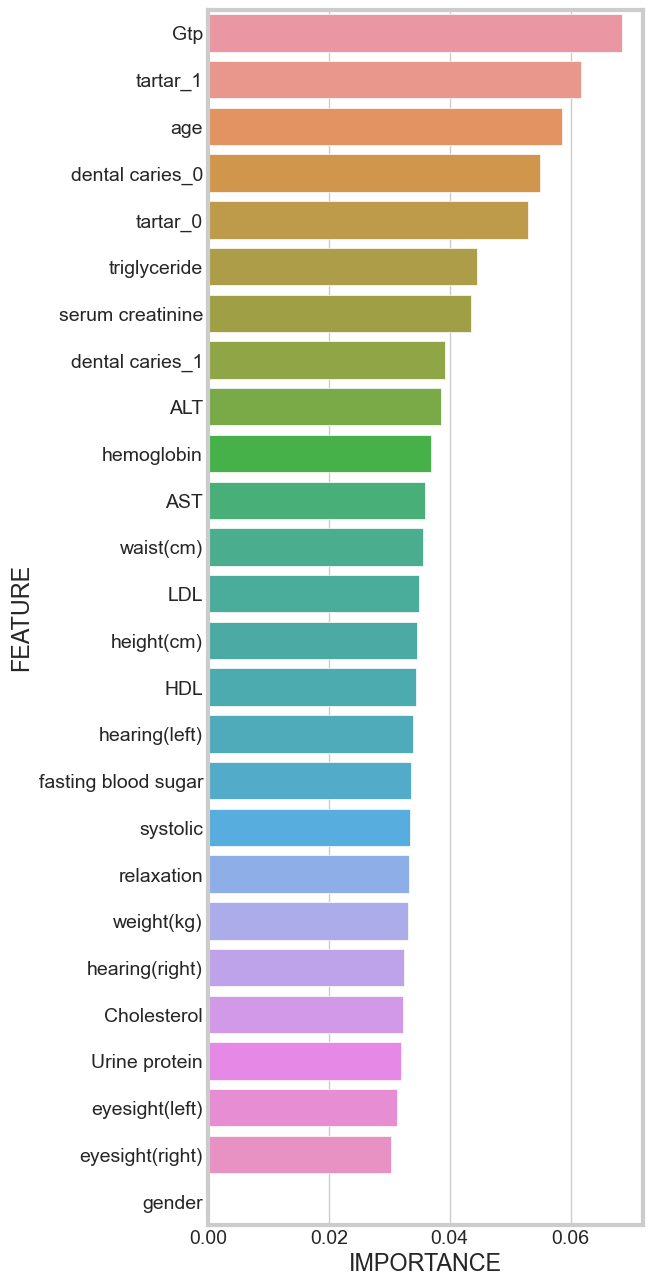

In [45]:
fi = pd.DataFrame(columns=['FEATURE', 'IMPORTANCE'])
fi['FEATURE'] = X_train_o.columns
fi['IMPORTANCE'] = clf.feature_importances_
fi = fi.sort_values('IMPORTANCE', ascending=False)
plt.figure(figsize=(5,15))
sns.barplot(y=fi.FEATURE, x=fi.IMPORTANCE)
plt.show()

Como podemos ver en los gráficos anteriores, no hay diferencias sustanciales en la performance del modelo tratando los outliers pero si los hay en la importancia de los features.

Generamos un archivo pickle de nuestro modelo.

In [46]:
'''param = {'max_depth': 3, 'learning_rate': 0.026936999073596618, 'n_estimators': 494,'gamma': 0.17924070626946773, 'min_child_weight': 1, 'subsample': 0.7245725300134859, 'colsample_bytree': 0.6696120345293278, 'lambda': 6.414180572488689e-06, 'alpha': 5.130620763187064e-06}

model = xgb.XGBClassifier(**params, use_label_encoder=False)
model.fit(X_train_o, y_train_o)
# Guardar el modelo en un archivo pickle
with open('modelo_xgboost.pkl', 'wb') as file:
    pickle.dump(model, file)'''

"param = {'max_depth': 3, 'learning_rate': 0.026936999073596618, 'n_estimators': 494,'gamma': 0.17924070626946773, 'min_child_weight': 1, 'subsample': 0.7245725300134859, 'colsample_bytree': 0.6696120345293278, 'lambda': 6.414180572488689e-06, 'alpha': 5.130620763187064e-06}\n\nmodel = xgb.XGBClassifier(**params, use_label_encoder=False)\nmodel.fit(X_train_o, y_train_o)\n# Guardar el modelo en un archivo pickle\nwith open('modelo_xgboost.pkl', 'wb') as file:\n    pickle.dump(model, file)"

In [47]:
# Cargamos el modelo desde el archivo pickle
with open('modelo_xgboost.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Realizamos predicciones con el modelo cargado
y_pred = loaded_model.predict(X_test_o)

# Calculamos la precisión del modelo
accuracy = accuracy_score(y_test_o, y_pred)
print(f'Accuracy del modelo: {accuracy:.2f}')

FileNotFoundError: [Errno 2] No such file or directory: 'modelo_xgboost.pkl'

In [ ]:
loaded_model.predict(X_test_o)

array([0, 1, 0, ..., 1, 0, 1])

Creamos un pipeline para aplicar al dataset

# Probamos la performance del modelo con la regla dura incluyendo el género femenino

In [ ]:


# Creamos una copia del DataFrame para las predicciones
df_pred = original_df.copy()
df_pred['gender'] = df_pred['gender'].replace({'M': 1, 'F': 0})
df_pred['tartar'] = df_pred['tartar'].replace({'Y': 1, 'N': 0})
columns_to_encode = ['tartar','dental caries']
df_pred = mf.encode_df(df_pred, columns_to_encode)
mf.transformar_asimetricas(df_pred)
mf.normalizar(df_pred)

# Separamos las características (X) y la variable objetivo (y)
X = df_pred.drop('smoking', axis=1)
y_true = df_pred['smoking']


# Aplicamos la regla dura: cuando gender sea 'F', la predicción de smoking es 0
df_pred.loc[df_pred['gender'] == 0, 'smoking_pred'] = 0

# Para los demás casos, usamos el modelo para predecir
X_model = df_pred[df_pred['gender'] == 1].drop(['smoking', 'smoking_pred'], axis=1)
smoking_pred_model = loaded_model.predict(X_model)

# Colocamos las predicciones del modelo en el DataFrame
mask_male = df_pred['gender'] == 1

index_male = df_pred.index[mask_male].tolist()
for idx, pred in zip(index_male, smoking_pred_model):
    df_pred.at[idx, 'smoking_pred'] = pred

# Calculamos la accuracy
accuracy = accuracy_score(y_true, df_pred['smoking_pred'])
print(f'Accuracy: {accuracy:.3f}')


NameError: name 'encode_df' is not defined

Podemos observar que la performance del modelo con la regla dura da un acuraccy del 73.3%.

# Probamos sin sacar el genero femenino

In [ ]:
df_completo = original_df.copy()
# Reemplazamos 'Y' por 1 y 'N' por 0 en todo el DataFrame
df_completo['tartar'] = df_completo['tartar'].replace({'Y': 1, 'N': 0})
df_completo['gender'] = df_completo['gender'].replace({'F': 1, 'M': 0})


In [ ]:
# Eliminamos columnas innecesarias  
columns_to_drop = ['ID','oral']
df_completo.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Encodeamos el df
columns_to_encode = ['tartar','dental caries','gender']

df_completo = mf.encode_df(df_completo,columns_to_encode)

In [ ]:
# Transformamos las variables con distribución asiméticas del df_completo
mf.transformar_asimetricas(df_completo)

# Normalizamos las variables con distribución normal del df_completo
mf.normalizar(df_completo)

In [ ]:
columnas_outliers=['weight(kg)','waist(cm)','systolic','relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride','LDL', 'hemoglobin','serum creatinine', 'AST', 'ALT', 'Gtp']

# Tratamos los outliers
mf.remove_outliers(df_completo, columnas_outliers)

In [ ]:
# Dividimos en train y test el dataframe
X_train, X_test, y_train, y_test = mf.split(df_completo)

In [ ]:
'''# Función objetiva para optimización
def objective(trial):
    # Sugerimos valores para los hiperparámetros
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',  # Usamos softmax para clasificación multiclase
        'num_class': 3,  # Cambia según el número de clases en tu dataset
        'eval_metric': 'mlogloss',  # Usamos log loss para la evaluación
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }
    
    # Creamos el clasificador con los hiperparámetros sugeridos
    clf = xgb.XGBClassifier(**param, use_label_encoder=False)
    
    # Evaluar el modelo usando validación cruzada
    scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
    accuracy = scores.mean()
    
    return accuracy

# Creamos el estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Mostramos los mejores hiperparámetros encontrados
print("Número de pruebas: ", len(study.trials))
print("Mejores hiperparámetros: ", study.best_params)
print("Mejor valor objetivo: ", study.best_value)

# Entrenamos el modelo final con los mejores hiperparámetros
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
best_model.fit(X_train, y_train)

# Evaluamos el modelo en el conjunto de prueba
test_accuracy = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")'''

'# Función objetiva para optimización\ndef objective(trial):\n    # Sugerir valores para los hiperparámetros\n    param = {\n        \'verbosity\': 0,\n        \'objective\': \'multi:softmax\',  # Usamos softmax para clasificación multiclase\n        \'num_class\': 3,  # Cambia según el número de clases en tu dataset\n        \'eval_metric\': \'mlogloss\',  # Usamos log loss para la evaluación\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 5),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 1e-5, 1.0),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 500),\n        \'gamma\': trial.suggest_loguniform(\'gamma\', 1e-8, 1.0),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.5, 1.0),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.5, 1.0),\n        \'lambda\': trial.suggest_loguniform(\'lambda\', 1e-8, 1.0),\n      

In [ ]:
param = {'max_depth': 3, 'learning_rate': 0.22050935552508527, 'n_estimators': 496, 'gamma': 0.004140020658340725, 'min_child_weight': 5, 'subsample': 0.8454373450184768, 'colsample_bytree': 0.8676168901117415, 'lambda': 3.241932151223007e-05, 'alpha': 1.4573335643556732e-05}
xgb_classifier(X_train,X_test,y_train,y_test,param)


              precision    recall  f1-score   support

           0       0.86      0.84      0.85     25337
           1       0.74      0.77      0.76     14663

    accuracy                           0.82     40000
   macro avg       0.80      0.81      0.80     40000
weighted avg       0.82      0.82      0.82     40000

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      6334
           1       0.68      0.71      0.69      3666

    accuracy                           0.77     10000
   macro avg       0.75      0.76      0.76     10000
weighted avg       0.77      0.77      0.77     10000



In [ ]:
clf = xgb.XGBClassifier(**param, use_label_encoder=False)
clf.fit(X_train, y_train)
train_pred=clf.predict(X_train)
test_pred = clf.predict(X_test)

print(classification_report(y_train,train_pred))
print('---------------------------------------------------------------')
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     25337
           1       0.74      0.77      0.76     14663

    accuracy                           0.82     40000
   macro avg       0.80      0.81      0.80     40000
weighted avg       0.82      0.82      0.82     40000

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      6334
           1       0.68      0.71      0.69      3666

    accuracy                           0.77     10000
   macro avg       0.75      0.76      0.76     10000
weighted avg       0.77      0.77      0.77     10000



Validamos la performance del modelo con K-Fold cross validation

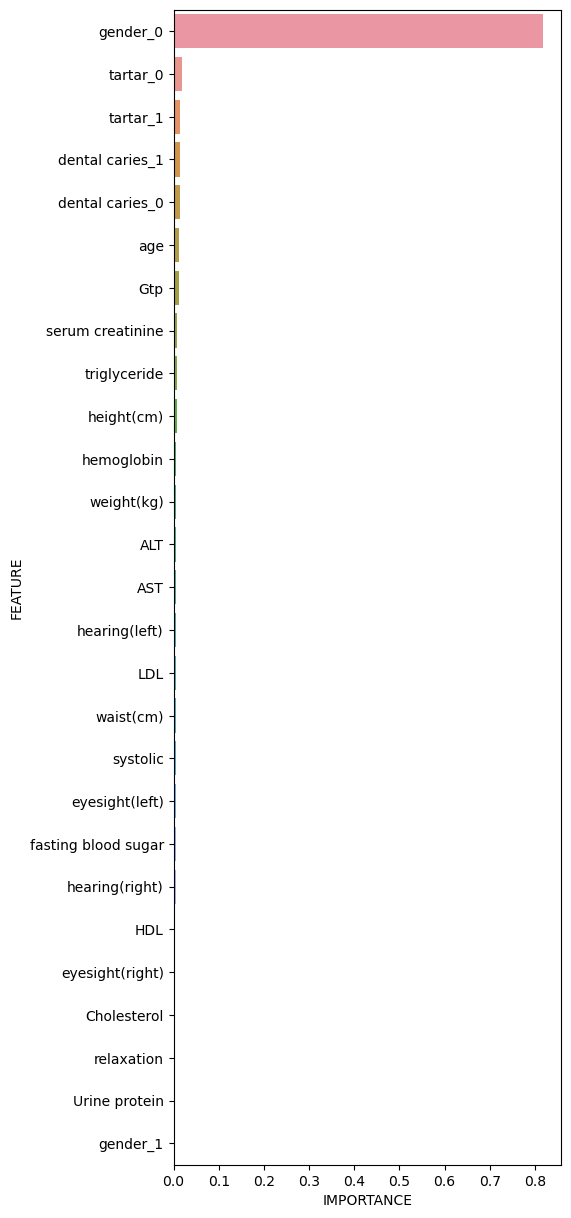

In [ ]:
fi = pd.DataFrame(columns=['FEATURE', 'IMPORTANCE'])
fi['FEATURE'] = X_train.columns
fi['IMPORTANCE'] = clf.feature_importances_
fi = fi.sort_values('IMPORTANCE', ascending=False)
plt.figure(figsize=(5,15))
sns.barplot(y=fi.FEATURE, x=fi.IMPORTANCE)
plt.show()

Podemos observar como la variable gender_0, perteneciente al género femenino, es la más importante para el modelo.

In [ ]:
cv_scores_xgb = cross_val_score(clf, X_train, y_train,scoring='accuracy', cv=25)

In [ ]:
print("CV scores para el modelo XGBoost:", cv_scores_xgb)
print(" CV score promedio para el modelo XGBoost:", cv_scores_xgb.mean())

CV scores para el modelo XGBoost: [0.783125 0.771875 0.7625   0.775625 0.769375 0.796875 0.7525   0.733125
 0.768125 0.7625   0.7675   0.746875 0.77     0.7675   0.753125 0.78
 0.765625 0.78125  0.761875 0.76     0.756875 0.761875 0.77125  0.78125
 0.759375]
 CV score promedio para el modelo XGBoost: 0.7664


In [ ]:
# Guardamos el modelo en un archivo pickle
with open('modelo_xgboost_final.pkl', 'wb') as file:
    pickle.dump(clf, file)

Podemos concluir que el modelo sin la regla dura tiene mejor performance (77.6% accuracy) que el que la tiene (73% accuracy).

Ahora procedemos a realizar la predicción en el dataset que no cuenta con la variable 'smoking'.

In [ ]:
# Cargamos el modelo desde el archivo pickle
with open('modelo_xgboost_final.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
df_entrega_original = pd.read_excel('smoking_prediction_entrega.xlsx')

df_entrega = df_entrega_original.copy()

In [ ]:
# Dropeamos las columnas ID y oral porque no nos aporta información para la predicción
df_entrega.drop(columns=['ID','oral'], inplace=True)

In [ ]:
# Encodeamos las features gender y tartar del dataframe
mf.label_encode(df_entrega)

In [ ]:
# Transformamos las variables con distribución asiméticas del dataframe
mf.transformar_asimetricas(df_entrega)

In [ ]:
# Normalizamos las variables con distribución asiméticas del dataframe
mf.normalizar(df_entrega)



In [ ]:
# Encodeamos las features tartar y dental caries del dataframe
columns_to_encode = ['tartar','dental caries']
df_entrega = mf.encode_df(df_entrega,columns_to_encode)

In [ ]:
# Realizamos predicciones con el modelo cargado
y_pred = loaded_model.predict(df_entrega)

# Verificamos que la longitud de y_pred coincide con la del DataFrame
assert len(y_pred) == len(df_entrega), "La longitud de las predicciones no coincide con la longitud del DataFrame"

# Agregamos la columna 'smoking' al DataFrame con los valores de y_pred
df_entrega_original['smoking'] = y_pred

# Guardamos el DataFrame actualizado de nuevo en un archivo Excel
df_entrega_original.to_excel('smoking_prediction_entrega.xlsx', index=False)

# Conclusión

### Realizando pruebas con diversos modelos, pude concluir que XGBoost es el que mejor performance tuvo. En base a esto, probando con la regla dura y sin ella, pude concluir que sin ésta el modelo arroja una mejor accuracy.